<a href="https://colab.research.google.com/github/Nouran246/Fruits-Recognition/blob/main/fruits_recognition_using_all_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
utkarshsaxenadn_fruits_classification_path = kagglehub.dataset_download('utkarshsaxenadn/fruits-classification')

print('Data source import complete.')


Data source import complete.


In [2]:
import os
import numpy as np
from skimage.feature import hog  # Import the hog function
import cv2
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.cm as cm
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import tensorflow as tf
from sklearn.metrics import confusion_matrix
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
from tqdm import tqdm
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from skimage import exposure
from google.colab.patches import cv2_imshow
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
print(f"Dataset downloaded to: {utkarshsaxenadn_fruits_classification_path}")

Dataset downloaded to: /root/.cache/kagglehub/datasets/utkarshsaxenadn/fruits-classification/versions/1


In [3]:
# Define image size
IMAGE_SIZE = (224, 224)  # You can adjust this as needed
train_dir = '/root/.cache/kagglehub/datasets/utkarshsaxenadn/fruits-classification/versions/1/Fruits Classification/train'
valid_dir = '/root/.cache/kagglehub/datasets/utkarshsaxenadn/fruits-classification/versions/1/Fruits Classification/valid'
test_dir = '/root/.cache/kagglehub/datasets/utkarshsaxenadn/fruits-classification/versions/1/Fruits Classification/test'

class_names = sorted(os.listdir(train_dir))



In [4]:
# Function to convert image to grayscale
def convert_to_gray(img, image_size):
    resized_img = cv2.resize(img, image_size)
    gray_img = cv2.cvtColor(resized_img, cv2.COLOR_BGR2GRAY)
    return gray_img

In [5]:
# Function to extract HOG features
def extract_hog_features(gray_img):
    try:
        if len(gray_img.shape) != 2:
            raise ValueError("Input image must be a 2D grayscale image.")
        features, hog_image = hog(
            gray_img,
            orientations=9,
            pixels_per_cell=(16, 16),
            cells_per_block=(2, 2),
            block_norm='L2-Hys',
            visualize=True,
            feature_vector=True
        )
        return features, hog_image
    except Exception as e:
        print(f"Error in HOG feature extraction: {e}")
        return None, None

In [6]:
from sklearn.cluster import KMeans
import numpy as np
import cv2

# Enhanced image segmentation using K-means and Canny edge detection
def segment_image_with_edges(img, k=3, canny_threshold1=100, canny_threshold2=200):
    try:
        if img is None:
            raise ValueError("Input image is None. Please check the image path.")

        # Preprocess the image (apply Gaussian blur to reduce noise)
        blurred_img = cv2.GaussianBlur(img, (5, 5), 0)

        # Apply Canny edge detection
        gray_img = cv2.cvtColor(blurred_img, cv2.COLOR_BGR2GRAY)
        edges = cv2.Canny(gray_img, threshold1=canny_threshold1, threshold2=canny_threshold2)

        # Reshape and normalize the color features
        reshaped_img = blurred_img.reshape((-1, 3))
        reshaped_img = np.float32(reshaped_img)

        # Add spatial features (coordinates) and edge features
        h, w, _ = img.shape
        coords = np.indices((h, w)).transpose(1, 2, 0).reshape(-1, 2)  # Pixel coordinates
        edge_flat = edges.flatten() / 255.0  # Normalize edge values (0 or 1)

        features = np.hstack((reshaped_img, coords, edge_flat[:, np.newaxis]))

        # Normalize features (color, spatial, edge)
        features[:, :3] /= 255.0  # Normalize color values
        features[:, 3:5] /= max(h, w)  # Normalize spatial coordinates

        # Apply K-means clustering
        kmeans = KMeans(n_clusters=k, random_state=42)
        labels = kmeans.fit_predict(features)

        # Create the segmented image using cluster centers
        segmented_img = kmeans.cluster_centers_[:, :3][labels].reshape((h, w, 3))
        segmented_img = (segmented_img * 255).astype(np.uint8)

        return segmented_img, labels.reshape((h, w)), edges
    except Exception as e:
        print(f"Error in image segmentation: {e}")
        return img, None, None

In [7]:
# Function for image restoration using Gaussian Blur
def restore_image(img, kernel_size=(5, 5)):
    try:
        if img is None:
            raise ValueError("Input image is None. Please check the image path.")
        restored_img = cv2.GaussianBlur(img, kernel_size, 0)
        return restored_img
    except Exception as e:
        print(f"Error in image restoration: {e}")
        return img

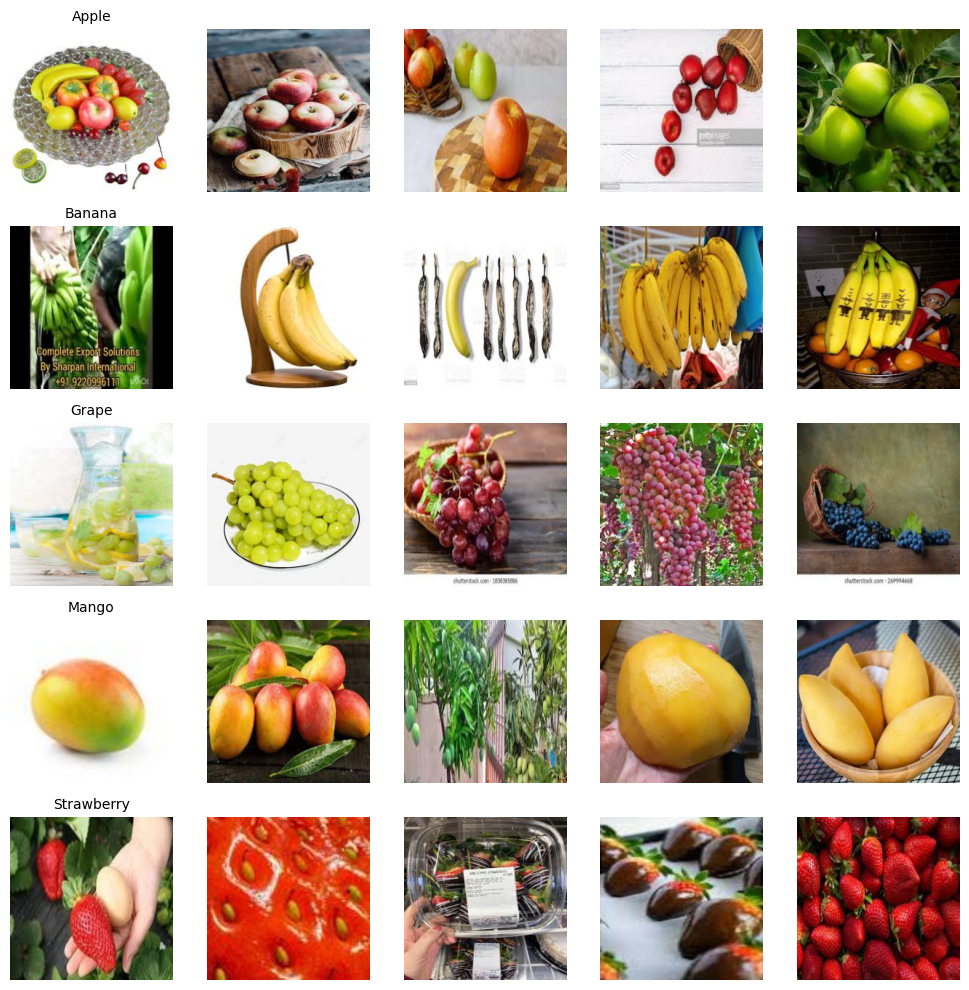

In [8]:
# Function to display sample images
def display_sample_images(data_dir, class_names, n_images=5):
    fig, axes = plt.subplots(len(class_names), n_images, figsize=(n_images * 2, len(class_names) * 2))
    for i, class_name in enumerate(class_names):
        class_path = os.path.join(data_dir, class_name)
        images = os.listdir(class_path)[:n_images]
        for j, img_name in enumerate(images):
            img_path = os.path.join(class_path, img_name)
            img = cv2.imread(img_path)
            if img is not None:
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                ax = axes[i, j]
                ax.imshow(cv2.resize(img, IMAGE_SIZE))
                ax.axis('off')
                if j == 0:
                    ax.set_title(class_name, fontsize=10)
    plt.tight_layout()
    plt.show()
         # Display sample images
display_sample_images(train_dir, class_names, n_images=5)

Displaying the images...


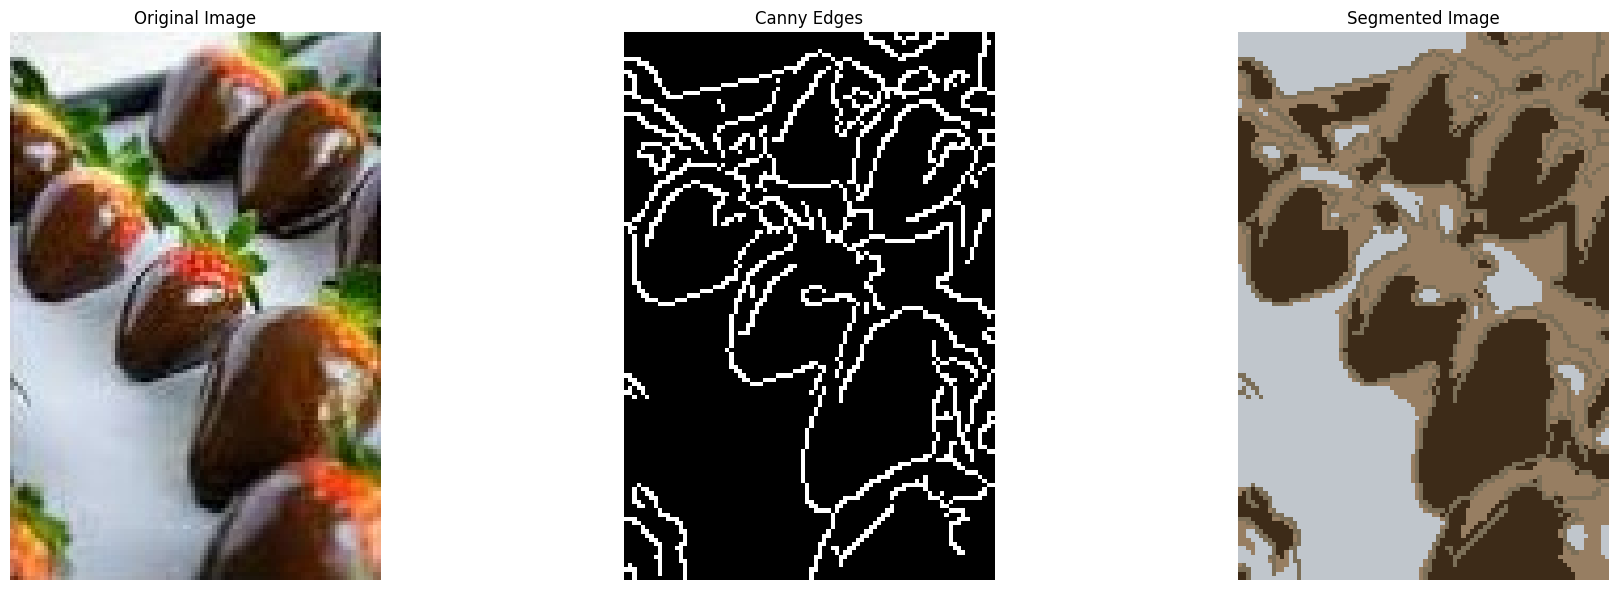

In [9]:
# Example usage
image_path = os.path.join(train_dir, class_names[4], os.listdir(os.path.join(train_dir, class_names[4]))[3])
image = cv2.imread(image_path)

if image is None:
    print(f"Failed to load image from path: {image_path}")
else:
    # Perform segmentation with edges
    segmented_image, labels, edges = segment_image_with_edges(image, k=4)

    # Display the original, edges, and segmented images horizontally
    print("Displaying the images...")

    # Create a horizontal plot
    plt.figure(figsize=(20, 6))

    # Original Image
    plt.subplot(1, 3, 1)
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB for display
    plt.title("Original Image")
    plt.axis("off")

    # Canny Edges
    plt.subplot(1, 3, 2)
    plt.imshow(edges, cmap='gray')  # Show edges in grayscale
    plt.title("Canny Edges")
    plt.axis("off")

    # Segmented Image
    plt.subplot(1, 3, 3)
    plt.imshow(cv2.cvtColor(segmented_image, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB for display
    plt.title("Segmented Image")
    plt.axis("off")

    plt.tight_layout()
    plt.show()

In [10]:
def visualize_preprocessing_steps(image_path, image_size):
    original_img = cv2.imread(image_path)
    if original_img is None:
        print(f"Image at {image_path} could not be loaded.")
        return

    # Convert to grayscale
    gray_img = convert_to_gray(original_img, image_size)

    # Extract HOG features
    hog_features, hog_image = extract_hog_features(gray_img)

    if hog_image is not None:
        # Rescale the HOG image for better visualization
        hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))

        # Perform segmentation (this should return segmented image and labels)
        segmented_image, labels, edges = segment_image_with_edges(original_img, k=4)

        # Display images using matplotlib in the specified order
        fig, axes = plt.subplots(1, 4, figsize=(20, 4))

        # Original Image
        axes[0].imshow(cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB))
        axes[0].set_title("Original Image")
        axes[0].axis("off")

        # Grayscale Image
        axes[1].imshow(gray_img, cmap="gray")
        axes[1].set_title("Grayscale Image")
        axes[1].axis("off")

        # Segmented Image
        axes[2].imshow(cv2.cvtColor(segmented_image, cv2.COLOR_BGR2RGB))
        axes[2].set_title("Segmented Image")
        axes[2].axis("off")

        # HOG Visualization
        axes[3].imshow(hog_image_rescaled, cmap="hot")
        axes[3].set_title("HOG Visualization")
        axes[3].axis("off")

        plt.tight_layout()
        plt.show()

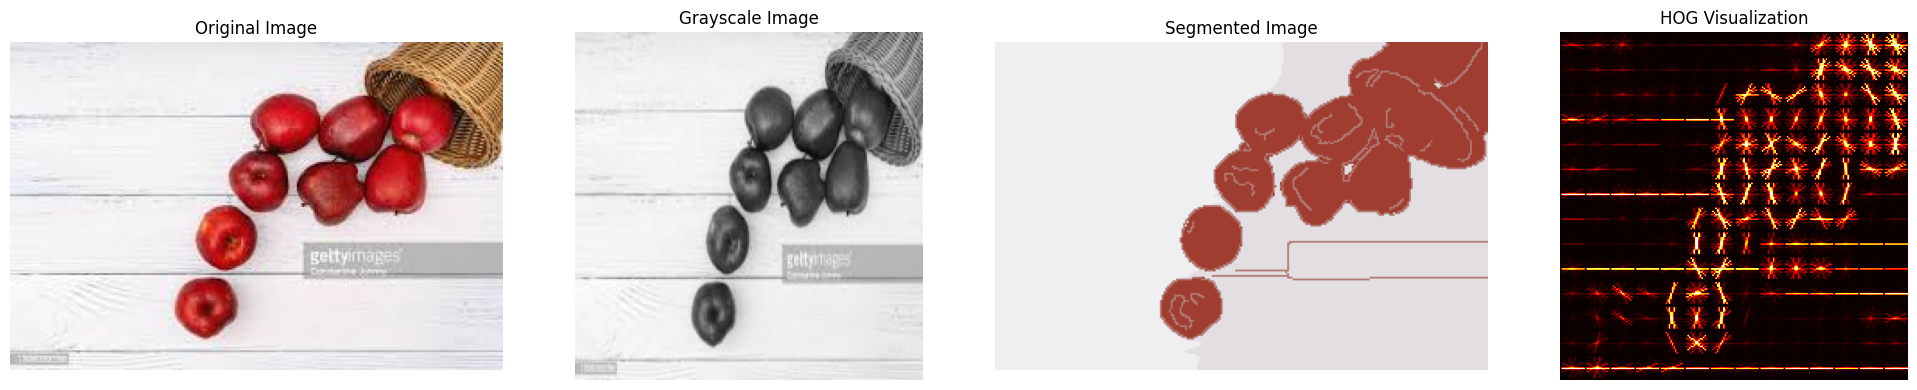

In [11]:
# Test the visualization function
from skimage import exposure
sample_image_path = os.path.join(train_dir, class_names[0], os.listdir(os.path.join(train_dir, class_names[0]))[3])
visualize_preprocessing_steps(sample_image_path, IMAGE_SIZE)

In [12]:
def load_images(data_dir, image_size, k=3, restoration_kernel_size=(5, 5)):
    images = []
    labels = []
    segmented_images = []
    restored_images = []
    valid_images = 0  # Track number of valid images processed

    for label, class_name in enumerate(class_names):
        class_dir = os.path.join(data_dir, class_name)
        for img_name in tqdm(os.listdir(class_dir), desc=f"Loading {class_name}"):
            img_path = os.path.join(class_dir, img_name)
            img = cv2.imread(img_path)

            if img is None:
                print(f"Skipping {img_path} as it could not be loaded.")
                continue  # Skip if image is not valid

            try:
                # Resize image to fixed size and convert to grayscale
                resized_img = cv2.resize(img, image_size)
                gray_img = convert_to_gray(resized_img, image_size)

                # Extract HOG features (ensure features are consistent)
                features, _ = extract_hog_features(gray_img)

                # Perform segmentation and restoration (resize to ensure consistency)
                segmented_img, _, _ = segment_image_with_edges(resized_img, k)  # You can adjust k for clusters
                restored_img = restore_image(resized_img, restoration_kernel_size)

                # Ensure features are not None and append resized images
                if features is not None:
                    images.append(features)
                    labels.append(label)
                    segmented_images.append(cv2.resize(segmented_img, image_size))  # Resize segmented image
                    restored_images.append(cv2.resize(restored_img, image_size))  # Resize restored image
                    valid_images += 1  # Count the valid image
                else:
                    print(f"Skipping {img_path} due to feature extraction failure.")
            except Exception as e:
                print(f"Error processing {img_path}: {e}")

    # Log the number of valid images processed
    print(f"Total valid images processed: {valid_images}")

    # Convert lists to numpy arrays
    return np.array(images), np.array(labels), np.array(segmented_images), np.array(restored_images)



In [13]:
# Save processed data
def save_processed_data(images, labels, segmented_images, restored_images):
    with open("processed_data.pkl", "wb") as f:
        pickle.dump((images, labels, segmented_images, restored_images), f)
    print("Processed data saved to 'processed_data.pkl'")

In [14]:
import os
import pickle

# Check if processed data exists
processed_data_file = "processed_data.pkl"

# Load or process the dataset
if os.path.exists("processed_data.pkl"):
    print("Loading processed data from file...")
    with open("processed_data.pkl", "rb") as f:
        images, labels, segmented_images, restored_images = pickle.load(f)
    print("Processed data loaded successfully!")
else:
    print("Processed data not found. Processing images...")
    images, labels, segmented_images, restored_images = load_images(train_dir, IMAGE_SIZE)
    save_processed_data(images, labels, segmented_images, restored_images)


Loading processed data from file...
Processed data loaded successfully!


In [15]:
# Split the dataset
from sklearn.model_selection import train_test_split

# Splitting into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)

print("Training and testing sets created:")
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

Training and testing sets created:
X_train shape: (7760, 6084), y_train shape: (7760,)
X_test shape: (1940, 6084), y_test shape: (1940,)


In [16]:
from sklearn.preprocessing import StandardScaler

# Scale features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [19]:
from sklearn.svm import SVC
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score, recall_score, f1_score

# Define the parameter search space for SVM
param_distributions_svm = {
    'C': [0.1, 1, 10],  # Reduced range
    'kernel': ['linear', 'rbf'],  # Most commonly effective kernels
    'gamma': ['scale'],  # Stick to one option for simplicity
    'tol': [1e-3],  # Fixed value
}


# Initialize the SVM model
svm_model = SVC(class_weight='balanced', random_state=42)

# Perform RandomizedSearchCV
print("\nPerforming Randomized Search for SVM...")
random_search_svm = RandomizedSearchCV(
    svm_model,
    param_distributions=param_distributions_svm,
    n_iter=5,  # Reduced number of iterations
    cv=3,
    scoring='accuracy',
    random_state=42,
    n_jobs=-1,
)
random_search_svm.fit(X_train, y_train)

# Retrieve best parameters and evaluate on the test set
print(f"Best parameters for SVM: {random_search_svm.best_params_}")
best_svm_model = random_search_svm.best_estimator_
y_pred_svm = best_svm_model.predict(X_test)
accuracy_svm = accuracy_score(y_test, y_pred_svm)

# Output results for SVM
print(f"SVM Accuracy: {accuracy_svm * 100:.2f}%")
print("\nSVM Classification Report:")
print(classification_report(y_test, y_pred_svm, zero_division=1))  # No class names specified
print("\nSVM Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_svm))  # Plain confusion matrix

# Calculate precision, recall, and F1-score for SVM
precision_svm = precision_score(y_test, y_pred_svm, average='weighted', zero_division=1)
recall_svm = recall_score(y_test, y_pred_svm, average='weighted', zero_division=1)
f1_svm = f1_score(y_test, y_pred_svm, average='weighted', zero_division=1)

# Print the metrics for SVM
print(f"Precision: {precision_svm:.2f}")
print(f"Recall: {recall_svm:.2f}")
print(f"F1-score: {f1_svm:.2f}")



Performing Randomized Search for SVM...
Best parameters for SVM: {'tol': 0.001, 'kernel': 'rbf', 'gamma': 'scale', 'C': 10}
SVM Accuracy: 46.80%

SVM Classification Report:
              precision    recall  f1-score   support

           0       0.39      0.39      0.39       404
           1       0.47      0.45      0.46       371
           2       0.51      0.48      0.49       393
           3       0.51      0.61      0.55       389
           4       0.46      0.42      0.44       383

    accuracy                           0.47      1940
   macro avg       0.47      0.47      0.47      1940
weighted avg       0.47      0.47      0.47      1940


SVM Confusion Matrix:
[[156  63  43  83  59]
 [ 64 167  42  67  31]
 [ 65  30 188  39  71]
 [ 51  50  25 236  27]
 [ 66  47  72  37 161]]
Precision: 0.47
Recall: 0.47
F1-score: 0.47


In [20]:
import joblib

# Save the best SVM model to a file
model_filename = "svm_best_model.pkl"
joblib.dump(best_svm_model, model_filename)
print(f"Model saved to {model_filename}")


Model saved to svm_best_model.pkl


In [21]:
import os
import joblib
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
# Define the parameter search space for Random Forest
param_distributions = {
    'n_estimators': [50, 100, 150, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
}
# Initialize the Random Forest model
rf_model = RandomForestClassifier(random_state=42, class_weight='balanced')
# Define the model filename
model_filename = "random_forest_best_model.pkl"

# Check if the model is already saved
if os.path.exists(model_filename):
    print(f"Loading saved model from {model_filename}...")
    best_rf_model = joblib.load(model_filename)  # Load the saved model
    print("Model loaded successfully!")

    # Evaluate on the test set
    y_pred = best_rf_model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)

    # Output results
    print(f"Random Forest Accuracy: {accuracy * 100:.2f}%")
    print("\nRandom Forest Classification Report:")
    print(classification_report(y_test, y_pred, zero_division=1))  # No class names specified
    print("\nRandom Forest Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))  # Plain confusion matrix

    # Calculate precision, recall, and F1-score
    precision = precision_score(y_test, y_pred, average='weighted', zero_division=1)
    recall = recall_score(y_test, y_pred, average='weighted', zero_division=1)
    f1 = f1_score(y_test, y_pred, average='weighted', zero_division=1)

    # Print the metrics
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"F1-score: {f1:.2f}")

else:
    print("\nPerforming Randomized Search for Random Forest...")

    # Perform RandomizedSearchCV
    random_search = RandomizedSearchCV(
        rf_model,
        param_distributions=param_distributions,
        n_iter=20,
        cv=5,
        scoring='accuracy',
        random_state=42,
        n_jobs=-1,
    )
    random_search.fit(X_train, y_train)

    # Retrieve best parameters and evaluate on the test set
    print(f"Best parameters for Random Forest: {random_search.best_params_}")
    best_rf_model = random_search.best_estimator_
    y_pred = best_rf_model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)

    # Output results
    print(f"Random Forest Accuracy: {accuracy * 100:.2f}%")
    print("\nRandom Forest Classification Report:")
    print(classification_report(y_test, y_pred, zero_division=1))  # No class names specified
    print("\nRandom Forest Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))  # Plain confusion matrix

    # Calculate precision, recall, and F1-score
    precision = precision_score(y_test, y_pred, average='weighted', zero_division=1)
    recall = recall_score(y_test, y_pred, average='weighted', zero_division=1)
    f1 = f1_score(y_test, y_pred, average='weighted', zero_division=1)

    # Print the metrics
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"F1-score: {f1:.2f}")

    # Save the model
    joblib.dump(best_rf_model, model_filename)
    print(f"Model saved to {model_filename}")



Performing Randomized Search for Random Forest...


/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Best parameters for Random Forest: {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_depth': None}
Random Forest Accuracy: 41.80%

Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.41      0.19      0.26       404
           1       0.41      0.40      0.40       371
           2       0.44      0.53      0.48       393
           3       0.44      0.52      0.48       389
           4       0.38      0.46      0.42       383

    accuracy                           0.42      1940
   macro avg       0.42      0.42      0.41      1940
weighted avg       0.42      0.42      0.41      1940


Random Forest Confusion Matrix:
[[ 77  69  68  97  93]
 [ 40 147  53  79  52]
 [ 16  26 209  48  94]
 [ 28  79  35 203  44]
 [ 25  40 110  33 175]]
Precision: 0.42
Recall: 0.42
F1-score: 0.41
Model saved to random_forest_best_model.pkl


In [26]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score, recall_score, f1_score
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical

# For KNN
print("\nPerforming Randomized Search for KNN...")
param_distributions_knn = {
    'n_neighbors': [3, 5, 7, 9],  # Range of neighbors
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan'],
}

# Initialize the KNN model
knn_model = KNeighborsClassifier()

# Perform RandomizedSearchCV
random_search_knn = RandomizedSearchCV(
    knn_model,
    param_distributions=param_distributions_knn,
    n_iter=5,  # Reduced number of iterations
    cv=3,
    scoring='accuracy',
    random_state=42,
    n_jobs=-1,
)
random_search_knn.fit(X_train, y_train)
# Retrieve best parameters and evaluate on the test set
print(f"Best parameters for KNN: {random_search_knn.best_params_}")
best_knn_model = random_search_knn.best_estimator_
y_pred_knn = best_knn_model.predict(X_test)
accuracy_knn = accuracy_score(y_test, y_pred_knn)

# Output results for KNN
print(f"KNN Accuracy: {accuracy_knn * 100:.2f}%")
print("\nKNN Classification Report:")
print(classification_report(y_test, y_pred_knn, zero_division=1))
print("\nKNN Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_knn))

# Calculate precision, recall, and F1-score for KNN
precision_knn = precision_score(y_test, y_pred_knn, average='weighted', zero_division=1)
recall_knn = recall_score(y_test, y_pred_knn, average='weighted', zero_division=1)
f1_knn = f1_score(y_test, y_pred_knn, average='weighted', zero_division=1)

# Print the metrics for KNN
print(f"Precision: {precision_knn:.2f}")
print(f"Recall: {recall_knn:.2f}")
print(f"F1-score: {f1_knn:.2f}")


Performing Randomized Search for KNN...
Best parameters for KNN: {'weights': 'distance', 'n_neighbors': 7, 'metric': 'manhattan'}
KNN Accuracy: 36.55%

KNN Classification Report:
              precision    recall  f1-score   support

           0       0.31      0.41      0.35       404
           1       0.62      0.27      0.38       371
           2       0.29      0.50      0.37       393
           3       0.45      0.37      0.41       389
           4       0.41      0.27      0.32       383

    accuracy                           0.37      1940
   macro avg       0.42      0.36      0.37      1940
weighted avg       0.41      0.37      0.37      1940


KNN Confusion Matrix:
[[164  15 136  50  39]
 [ 92 102 108  40  29]
 [ 90  10 197  53  43]
 [ 93  28  85 143  40]
 [ 88  10 152  30 103]]
Precision: 0.41
Recall: 0.37
F1-score: 0.37


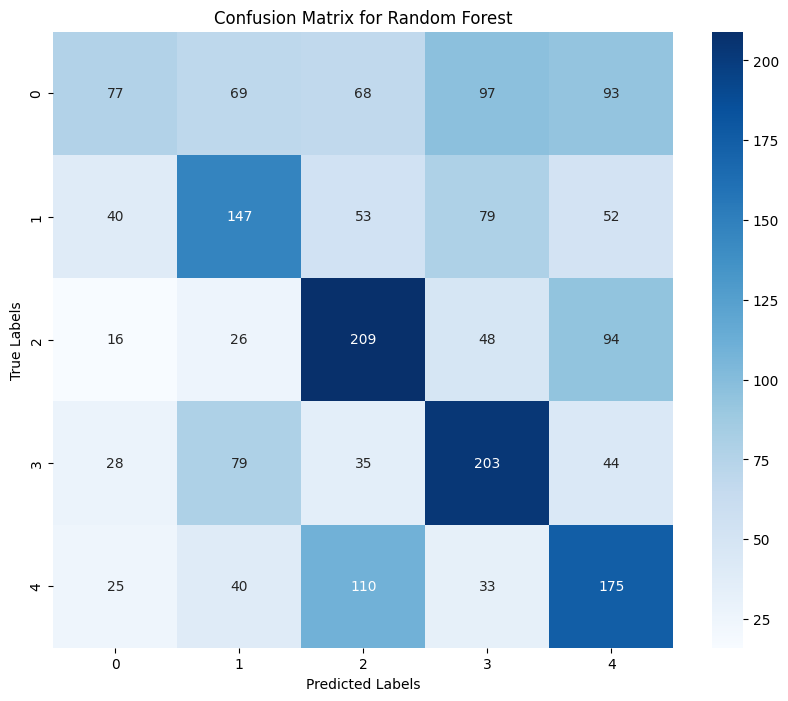

In [22]:
import seaborn as sns

# Predict the labels using the Random Forest model
y_pred_rf = best_rf_model.predict(X_test)

# Generate the confusion matrix for Random Forest
cm_rf = confusion_matrix(y_test, y_pred_rf)

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues')  # Removed xticklabels and yticklabels
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix for Random Forest')
plt.show()

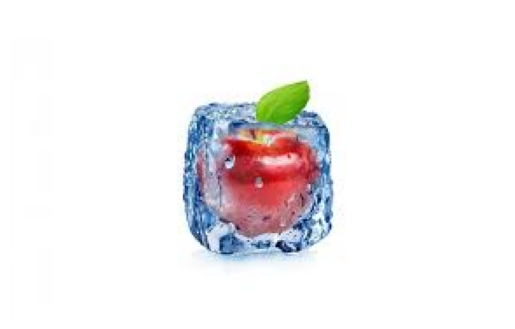

The predicted class for the image is: Apple


In [24]:
import os
import cv2
import numpy as np
import random
import matplotlib.pyplot as plt

# Define the preprocessing function (corrected)
def preprocess_image(image_path, image_size):
    # Load the image
    img = cv2.imread(image_path)
    if img is None:
        print(f"Error loading image at {image_path}")
        return None

    # Resize the image
    resized_img = cv2.resize(img, image_size)

    # Convert to grayscale
    gray_img = convert_to_gray(resized_img, image_size)

    # Extract HOG features
    hog_features, _ = extract_hog_features(gray_img)
    if hog_features is None:
        print(f"Error extracting HOG features for image {image_path}")
        return None

    return hog_features

# Define the prediction function (fixed)
def predict_image(image_path, model, scaler, image_size):
    # Preprocess the image (now using the correct function)
    hog_features = preprocess_image(image_path, image_size)
    if hog_features is None:
        return None

    # Scale the features using the same scaler used during training
    hog_features_scaled = scaler.transform([hog_features])

    # Make the prediction
    prediction = model.predict(hog_features_scaled)

    # Retrieve the class name based on the predicted label
    class_name = class_names[prediction[0]]

    return class_name

# Function to display the image in Colab
def show_image(image_path):
    # Load the image
    img = cv2.imread(image_path)
    if img is None:
        print("Error: Could not read image")
        return

    # Convert from BGR (OpenCV default) to RGB (Matplotlib expects)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Show the image
    plt.imshow(img_rgb)
    plt.axis('off')  # Hide the axis
    plt.show()

# Select a random image from the dataset
def get_random_image_path():
    random_class = random.choice(class_names)  # Randomly pick a class
    class_dir = os.path.join(train_dir, random_class)
    random_image_name = random.choice(os.listdir(class_dir))  # Randomly pick an image within the class directory
    return os.path.join(class_dir, random_image_name)

# Example usage of the prediction function
random_image_path = get_random_image_path()  # Get a random image path

# Show the image before prediction (only once)
show_image(random_image_path)

# Make the prediction for the image
predicted_class = predict_image(random_image_path, best_rf_model, scaler, IMAGE_SIZE)

if predicted_class:
    print(f"The predicted class for the image is: {predicted_class}")
else:
    print("Prediction failed.")
